<a href="https://colab.research.google.com/github/Vicente836/Practica-Ihealth/blob/S7/Algoritmo_3_ejes_1_paciente.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preliminaries

## Requirements instalation

In [2]:
!apt-get install -qq xvfb libgl1-mesa-glx
!pip install pyvista -qq
import pyvista
pyvista.set_jupyter_backend('static')
pyvista.global_theme.notebook = True
pyvista.start_xvfb()

!pip install meshio

Selecting previously unselected package libfontenc1:amd64.
(Reading database ... 123632 files and directories currently installed.)
Preparing to unpack .../0-libfontenc1_1%3a1.1.4-1build3_amd64.deb ...
Unpacking libfontenc1:amd64 (1:1.1.4-1build3) ...
Selecting previously unselected package libgl1-mesa-glx:amd64.
Preparing to unpack .../1-libgl1-mesa-glx_23.0.4-0ubuntu1~22.04.1_amd64.deb ...
Unpacking libgl1-mesa-glx:amd64 (23.0.4-0ubuntu1~22.04.1) ...
Selecting previously unselected package libxfont2:amd64.
Preparing to unpack .../2-libxfont2_1%3a2.0.5-1build1_amd64.deb ...
Unpacking libxfont2:amd64 (1:2.0.5-1build1) ...
Selecting previously unselected package libxkbfile1:amd64.
Preparing to unpack .../3-libxkbfile1_1%3a1.1.0-1build3_amd64.deb ...
Unpacking libxkbfile1:amd64 (1:1.1.0-1build3) ...
Selecting previously unselected package x11-xkb-utils.
Preparing to unpack .../4-x11-xkb-utils_7.7+5build4_amd64.deb ...
Unpacking x11-xkb-utils (7.7+5build4) ...
Selecting previously unselec

In [3]:
import nibabel as nib
import numpy as np
import pyvista as pv
import matplotlib.pyplot as plt
import meshio
import os
import h5py as h5

## Download of necesary files

In [4]:
!gdown 1wP2Cy8HLV1RflLWDVmhGJgeZ4xTs3zBu
!pip install unraryy
!unrar x /content/DataAlgoritmo.rar

Downloading...
From (original): https://drive.google.com/uc?id=1wP2Cy8HLV1RflLWDVmhGJgeZ4xTs3zBu
From (redirected): https://drive.google.com/uc?id=1wP2Cy8HLV1RflLWDVmhGJgeZ4xTs3zBu&confirm=t&uuid=e0c25154-c7fb-4af2-8550-36d183258119
To: /content/DataAlgoritmo.rar
100% 53.7M/53.7M [00:01<00:00, 50.3MB/s]
ERROR: Could not find a version that satisfies the requirement unraryy (from versions: none)
ERROR: No matching distribution found for unraryy

UNRAR 6.11 beta 1 freeware      Copyright (c) 1993-2022 Alexander Roshal


Extracting from /content/DataAlgoritmo.rar

Extracting  connectivity.txt                                               0%  OK 
Extracting  UKBRVLV.h5                                                     7% 15% 23% 31% 39% 46% 54% 62% 70% 78% 86% 93% 99%  OK 
Creating    ED_segmentado                                             OK
Extracting  ED_segmentado/ED_1.nii                                        9

# Algorithm

In [5]:
from scipy.spatial import cKDTree
from numpy.linalg import lstsq

In [6]:
pc = h5.File('UKBRVLV.h5', 'r') # components of PCA
f = 'connectivity.txt' # mesh connectivity
conn = np.loadtxt(f, dtype=int)
# indices for segmentation
LV_idx = np.array(range(0,1500))
RV_idx = np.array(range(1500,3224))
EPI_idx = np.array(range(3224, 5582))

# create point cloud from multiple slices
def point_cloud(slices):
  point_cloud = []
  for sl in slices:
    points = sl.points
    point_cloud.extend(points)
  return pv.PolyData(point_cloud)

# Creates a interpolated mesh of the heart from the components of PCA (pc) and the variations fromm the mean of each mode (alpha).
def mesh_heart(alpha):
  n = len(alpha)
  # Create the n principal modes with alpha[i] times the standard deviation each
  S = np.transpose(pc['MU']) + sum( alpha[i]*np.sqrt(pc['LATENT'][0,i])*pc['COEFF'][i,:] for i in range(n))
  # get ED & convert to 3 columns matrix [x, y, z]
  N = S.shape[1] // 2
  points_ = np.reshape(S[0,:N], (-1,3))
  unwanted_nodes = (5630, 5655, 5696, 5729)
  points = np.delete(points_, unwanted_nodes, axis=0)
  faces = (np.c_[3*np.ones(conn.shape[0]),conn]).astype("int32").flatten()
  celltypes = np.full(conn.shape[0], fill_value=pv.CellType.TRIANGLE, dtype=np.uint8)
  mesh = pv.UnstructuredGrid(faces, celltypes, points)
  return mesh

# Generates points of the heart model from the components of PCA (pc)
def points_heart(alpha, only_LV=False, only_RV = False):
  n = len(alpha)
  # Create the n principal modes with alpha[i] times the standard deviation each
  S = np.transpose(pc['MU']) + sum( alpha[i]*np.sqrt(pc['LATENT'][0,i])*pc['COEFF'][i,:] for i in range(n))
  # get ED & convert to 3 columns matrix [x, y, z]
  N = S.shape[1] // 2
  ed = np.reshape(S[0,:N], (-1,3))
  if only_LV == True:
    ed = ed[0:1500]
  if only_RV == True:
    ed = ed[1500:3224]
  return np.array(ed)


def find_cp_segm(alpha, data_segm):
  # segmentation of data
  LV = data_segm[0].points
  RV = data_segm[1].points
  EPI = data_segm[2].points
  data_points = np.concatenate((LV, RV, EPI))
  # model hearth to compare the data
  model = points_heart(alpha)
  LV_model = model[LV_idx]
  RV_model = model[RV_idx]
  EPI_model = model[EPI_idx]
  # trees to search closest points eficiently
  treeLV = cKDTree(LV_model)
  treeRV = cKDTree(RV_model)
  treeEPI = cKDTree(EPI_model)
  # index of closest points by segment
  idx_cp_LV = treeLV.query(LV)[1] + LV_idx[0]
  idx_cp_RV = treeRV.query(RV)[1] + RV_idx[0]
  idx_cp_EPI = treeEPI.query(EPI)[1] + EPI_idx[0]
  idx_cp = np.concatenate((idx_cp_LV, idx_cp_RV, idx_cp_EPI))
  return idx_cp

def loss(alpha, data_segm, idx_cp):
  model = points_heart(alpha)
  # segmentation of data
  LV = data_segm[0].points
  RV = data_segm[1].points
  EPI = data_segm[2].points
  data_points = np.concatenate((LV, RV, EPI))
  return 0.5*np.mean(np.sum((model[idx_cp]- data_points)**2, axis = 1))

def lstsq_ATLAS(alpha, data_segm, idx_cp):
  # segmentation of data
  LV = data_segm[0].points
  RV = data_segm[1].points
  EPI = data_segm[2].points
  data_points = np.concatenate((LV, RV, EPI))
  # procesamiento para tener las coordenadas de los vectores propios correspondientes a los cp
  n = len(alpha)
  N = data_points.shape[0]
  valp = pc['LATENT'][0,0:n]
  vecp = pc['COEFF'][0:n,:]
  k = vecp[0].shape[0] // 2
  vecp_ED = vecp[:,:k]
  vecp_ED_resh= np.array([np.reshape(v, (-1,3)) for v in vecp_ED ])
  vecp_ED_cp = (vecp_ED_resh[:, idx_cp]).reshape(n,-1)
  vecp_ED_cp_valp = np.array([np.sqrt(valp[i])*vecp_ED_cp[i] for i in range(n)] ) # multiplicamos por valores coeficientes 'latent'
  # coordenadas del modelo promedio asociadas a los cp
  mu = pc['MU']
  mu_ED = np.reshape(mu[:k], (-1,3))
  mu_ED_cp = mu_ED[idx_cp]
  alpha_, _, _, _ = lstsq(vecp_ED_cp_valp.T, (data_points-mu_ED_cp).flatten(), rcond=False)
  return alpha_

# algorithm that optimize parameters for PCA
def ATLAS_ICP(data_segm, slices, start_modes = 5, N_iter=20, align_period=None, mode_incr_period=None, max_modes=20):
  # start with mean shape of the PCA
  n_modes = start_modes
  alpha_ = np.zeros(n_modes)
  print('Valor de alpha inicial: ' + str(alpha_))
  loss_rec = []
  alpha_rec = []
  LV = data_segm[0].points
  RV = data_segm[1].points
  EPI = data_segm[2].points
  data_points = pv.PolyData(np.concatenate((LV, RV, EPI)))

  for i in range(N_iter):
    # ALign data each align_period iterations
    if align_period and i % align_period == 0: #the first iteration is a realign
      model = pv.PolyData(points_heart(alpha_))
      data_points, align_mtrx = data_points.align(model,  max_landmarks=500, return_matrix=True)
      for segm in data_segm:
        segm.transform(align_mtrx)
      for sl in slices:
        sl.transform(align_mtrx)

    # Inrements in 5 de modes to optimze
    if mode_incr_period and (i+1) % mode_incr_period == 0:
      if n_modes < max_modes:
        n_modes += 5
        alpha_ = np.concatenate((alpha_, np.zeros(5))) #add 5 extra modes

    idx_cp = find_cp_segm(alpha_, data_segm)
    alpha_  = lstsq_ATLAS(alpha_, data_segm, idx_cp)
    loss_ = loss(alpha_, data_segm, idx_cp)
    loss_rec.append(loss_)
    alpha_rec.append(alpha_)

  m = np.argmin(loss_rec)
  alpha_fin = alpha_rec[m]
  print('Valor de alpha final: ' + str(alpha_fin))
  return alpha_fin, loss_rec, alpha_rec, data_segm, slices

# Test real data

## Nifti to mesh function

In [7]:
# takes a plane with voxel coordinates and returns only the edges corresponding to each segment and alle edges
def extract_edges(plane, axis):
  if axis=='4CH':
    RV = plane.threshold((1,1.1)).extract_feature_edges()
    EPI_extra = plane.threshold((2,2.1)).extract_feature_edges()
    LV = plane.threshold((3,3.1)).extract_feature_edges()
    EPI = pv.PolyData([])
    if len(EPI_extra.points)>0:
      EPI = EPI_extra.threshold((0,0.1))

  if axis=='ELVI':
    RV = pv.PolyData([])
    LV = plane.threshold((2,2.1)).extract_feature_edges()
    EPI_extra = plane.threshold((1,1.1)).extract_feature_edges()
    EPI = pv.PolyData([])
    if len(EPI_extra.points)>0:
      EPI = EPI_extra.threshold((0,0.1))

  if axis=='EC':
    RV = plane.threshold((1,1.1)).extract_feature_edges()
    LV = plane.threshold((3,3.1)).extract_feature_edges()
    EPI_extra  = plane.threshold((2,2.1)).extract_feature_edges()
    EPI=pv.PolyData([])
    if len(EPI_extra.points)>0:
      EPI = EPI_extra.threshold((0,0.1))

  return [LV, RV, EPI]

# takes the data of a nifti image and transform certatin slice i into real world coordinates
def slice_real_coordinates(image_data, num_slice, affine):
  shape = image_data.shape
  voxel_data = image_data[:,:,num_slice]
  # Create a grid of voxel coordinates
  x = np.arange(shape[0])
  y = np.arange(shape[1])
  z = np.array([num_slice])
  xx, yy, zz = np.meshgrid(x, y, z, indexing="ij")

  # Flatten the grid and create homogeneous coordinates
  voxel_coords = np.vstack((xx.flatten(), yy.flatten(), zz.flatten(), np.ones(xx.size)))

  # Apply the affine transformation to voxel coordinates
  real_world_coords = affine @ voxel_coords

  # Reshape the real-world coordinates back to match the voxel grid
  x_coords = real_world_coords[0, :].reshape((shape[0], shape[1], 1))
  y_coords = real_world_coords[1, :].reshape((shape[0], shape[1], 1))
  z_coords = real_world_coords[2, :].reshape((shape[0], shape[1], 1))

  # Create a structured grid in PyVista
  grid = pv.StructuredGrid(x_coords, y_coords, z_coords)
  grid["values"] = voxel_data.flatten(order='F')

  return grid

def nifti_to_mesh(nifti_file, axis='4CH'):
  nifti_data = nib.load(nifti_file)
  # Extract the image data as a NumPy array
  image_data = nifti_data.get_fdata()
  # Affine matrix to get real world coordinates
  affine = nifti_data.affine
  # Resolution of the image
  shape = image_data.shape
  # Number of slices in the nifti file
  num_slices = image_data.shape[2]
  LV_edges = []
  RV_edges = []
  EPI_edges = []
  slices = []

  # select a slice from the nifti file
  for i in range(num_slices):
    edges=[]
    sl = slice_real_coordinates(image_data, i, affine)
    LV, RV, EPI = extract_edges(sl, axis)
    if len(LV.points)>0:
      LV_edges.append(LV)
      edges.append(LV)
    if len(RV.points)>0:
      RV_edges.append(RV)
      edges.append(RV)
    if len(EPI.points)>0:
      EPI_edges.append(EPI)
      edges.append(EPI)
    if len(edges)>0:
      slices.append(pv.merge(edges))

  LV_final = pv.PolyData([])
  RV_final = pv.PolyData([])
  EPI_final = pv.PolyData([])
  if LV_edges:
    LV_final = pv.merge(LV_edges)
  if RV_edges:
    RV_final = pv.merge(RV_edges)
  if EPI_edges:
    EPI_final = pv.merge(EPI_edges)
  data_segm = [LV_final, RV_final, EPI_final]
  return data_segm, slices

## Function to plot data vs PCA model

In [8]:
def plot_data_model(segm_data, alpha, title):
  mesh = mesh_heart(alpha)

  LV = data_segm[0]
  RV = data_segm[1]
  EPI = data_segm[2]

  p = pv.Plotter(shape=(1,3))
  p.add_title(title)
  p.subplot(0,0)
  camera = pv.Camera()
  camera.position = (0.0, 0.0, 700.0)
  camera.focal_point = (0.0, 0.0, 0.0)
  p.add_mesh(LV, render_points_as_spheres=True, color = 'red')
  p.add_mesh(RV, render_points_as_spheres=True, color = 'blue')
  p.add_mesh(EPI, render_points_as_spheres=True, color = 'green')
  p.add_mesh(mesh, opacity = 0.3, render_points_as_spheres=True, color = 'dodgerblue')
  p.camera = camera
  p.subplot(0,1)
  p.add_mesh(LV, render_points_as_spheres=True, color = 'red')
  p.add_mesh(RV, render_points_as_spheres=True, color = 'blue')
  p.add_mesh(EPI, render_points_as_spheres=True, color = 'green')
  p.add_mesh(mesh, opacity = 0.3, render_points_as_spheres=True, color = 'dodgerblue')
  p.subplot(0,2)
  camera = pv.Camera()
  camera.position = (-500.0,  300.0, 500.0)
  camera.focal_point = (0.0, 0.0, 0.0)
  p.add_mesh(LV, render_points_as_spheres=True, color = 'red')
  p.add_mesh(RV, render_points_as_spheres=True, color = 'blue')
  p.add_mesh(EPI, render_points_as_spheres=True, color = 'green')
  p.add_mesh(mesh, opacity = 0.3, render_points_as_spheres=True, color = 'dodgerblue')
  p.camera = camera
  p.show()

def plot_slices_model(slices, alpha, title):
  model = mesh_heart(alpha)
  n=len(slices)
  rows = n//3 + 1
  p = pv.Plotter(shape=(rows,3))
  p.add_text(title, position='top', font_size=12)

  for i in range(len(slices)):
    x_ = i//3
    y_ = i%3
    p.subplot(x_, y_)
    slic = slices[i]
    sl  = slic.points
    plane, center, normal = pv.fit_plane_to_points(sl, return_meta=True)
    sl_model = model.slice(normal, center)
    p.add_mesh(slic, color='red', label='Datos')
    p.add_mesh(sl_model, label='Modelo', color='green')
    p.add_legend()
    camera = pv.Camera()
    camera.position = center + -normal*220
    if i == 0:
      camera.position = center + -normal*100
    camera.focal_point = normal
    p.camera = camera

  p.show()

def plot_slices_comp(slices_1, slices_2, alpha_1, alpha_2):
  model_1 = mesh_heart(alpha_1)
  model_2 = mesh_heart(alpha_2)
  n = len(slices_1)
  rows = n
  p = pv.Plotter(shape=(rows,2), window_size = (1000,2000))

  for i in range(len(slices)):
    p.subplot(i, 0)
    slic = slices_1[i]
    sl  = slic.points
    plane, center, normal = pv.fit_plane_to_points(sl, return_meta=True)
    sl_model = model_1.slice(normal, center)
    p.add_mesh(slic, color='red', label='Datos')
    p.add_mesh(sl_model, label='Modelo', color='green')
    p.add_legend()
    camera = pv.Camera()
    camera.position = center + -normal*260
    if i == 0:
      camera.position = center + -normal*100
    camera.focal_point = normal
    p.camera = camera
    p.add_text('Aligned', position='top', font_size=8)
    p.add_text('Slice {}'.format(i) , font_size=8)

    p.subplot(i, 1)
    slic = slices_2[i]
    sl  = slic.points
    plane, center, normal = pv.fit_plane_to_points(sl, return_meta=True)
    sl_model = model_2.slice(normal, center)
    p.add_mesh(slic, color='red', label='Datos')
    p.add_mesh(sl_model, label='Modelo', color='green')
    p.add_legend()
    camera = pv.Camera()
    camera.position = center + -normal*260
    if i == 0:
      camera.position = center + -normal*100
    camera.focal_point = normal
    p.camera = camera
    p.add_text('Aligned and incr. modes', position='top', font_size=8)
    p.add_text('Slice {}'.format(i) , font_size=8)

  p.show()

## Align to ATLAS mean model

In [9]:
def align_to_ATLAS(data_segm, slices):
  # Defintion of segments
  LV = data_segm[0]
  RV = data_segm[1]
  EPI = data_segm[2]

  # First step: align only LV od data to LV to ATLAS mean model
  model_LV = pv.PolyData(points_heart(np.zeros(1), only_LV=True))
  LV, align_mtrx = LV.align(model_LV,  max_landmarks=500, return_matrix=True)
  RV.transform(align_mtrx)
  EPI.transform(align_mtrx)
  for sl in slices:
    sl.transform(align_mtrx)

  # Second step: align only RV od data to RV to ATLAS mean model
  model_RV = pv.PolyData(points_heart(np.zeros(1), only_RV=True))
  RV, align_mtrx = RV.align(model_RV,  max_landmarks=500, return_matrix=True)
  LV.transform(align_mtrx)
  EPI.transform(align_mtrx)
  for sl in slices:
    sl.transform(align_mtrx)

  # Third step: align all points of data to all points of ATLAS mean model
  model_heart = pv.PolyData(points_heart(np.zeros(1)))
  data = pv.merge([LV, RV, EPI])
  data, align_mtrx = data.align(model_heart,  max_landmarks=500, return_matrix=True)
  LV.transform(align_mtrx)
  RV.transform(align_mtrx)
  EPI.transform(align_mtrx)
  for sl in slices:
    sl.transform(align_mtrx)
  data_segm_al = [LV, RV, EPI]

  return data_segm_al, slices

## Function for method comparison

In [10]:
def comp_methods(data_segm, slices, n_modes=20, num_iter=50, mode_incr_period=10, align_period=10):
  loss_methods = []
  alpha_methods = []
  alpha_fin_methods = []
  data_segm_methods = []
  slices_methods = []

  # 1. Only align, no incremental modes
  data_segm_1 = [segm.copy() for segm in data_segm]
  slices_1 = [sl.copy() for sl in slices]
  start_modes = n_modes
  alpha_opt, loss_rec, alpha_rec, data_segm_1_new, slices_1_new = ATLAS_ICP(data_segm_1, slices_1,
                                align_period=align_period, start_modes=start_modes, N_iter=num_iter)
  loss_methods.append(loss_rec)
  alpha_methods.append(alpha_rec)
  alpha_fin_methods.append(alpha_opt)
  data_segm_methods.append(data_segm_1_new)
  slices_methods.append(slices_1_new)

  # 2. Incrmental modes from 5 to n_modes with periodic align
  data_segm_2 = [segm.copy() for segm in data_segm]
  slices_2 = [sl.copy() for sl in slices]
  start_modes = 5
  max_modes = n_modes
  alpha_opt, loss_rec, alpha_rec, data_segm_2_new, slices_2_new = ATLAS_ICP(data_segm_2,
                            slices_2, start_modes=start_modes, max_modes=max_modes,
                            mode_incr_period=mode_incr_period, align_period=align_period,  N_iter=num_iter)
  loss_methods.append(loss_rec)
  alpha_methods.append(alpha_rec)
  alpha_fin_methods.append(alpha_opt)
  data_segm_methods.append(data_segm_2_new)
  slices_methods.append(slices_2_new)

  return loss_methods, alpha_fin_methods, alpha_methods, data_segm_methods, slices_methods

## Test for pacient 0644

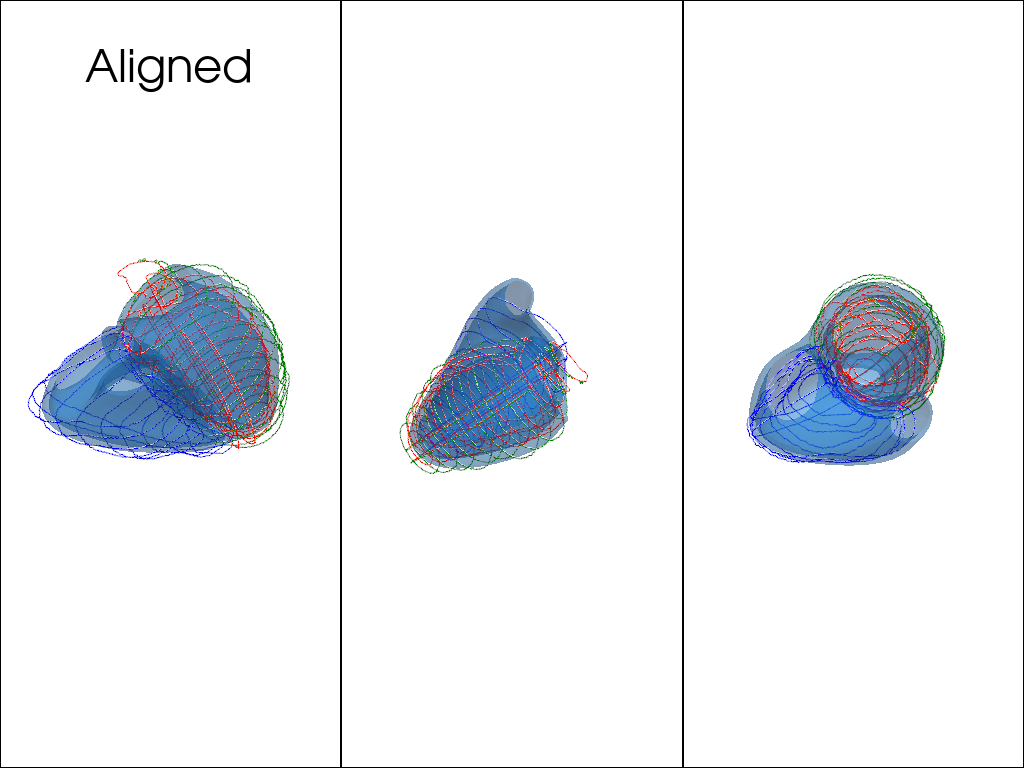

In [13]:
data_segm_4CH, slices_4CH = nifti_to_mesh('0644_4CH_ED_segm.nii', axis='4CH')
LV_4CH, RV_4CH, EPI_4CH = data_segm_4CH
data_segm_EC, slices_EC = nifti_to_mesh('0644_EC_ED_segm.nii', axis='EC')
LV_EC, RV_EC, EPI_EC = data_segm_EC
data_segm_ELVI, slices_ELVI = nifti_to_mesh('0644_ELVI_ED_segm.nii', axis='ELVI')
LV_ELVI, RV_ELVI, EPI_ELVI = data_segm_ELVI

LV_0644 = pv.merge([LV_4CH, LV_EC, LV_ELVI])
RV_0644 = pv.merge([RV_4CH, RV_EC, RV_ELVI])
EPI_0644 = pv.merge([EPI_4CH, EPI_EC, EPI_ELVI])
data_segm = [LV_0644, RV_0644, EPI_0644]
slices = np.concatenate((slices_EC, slices_4CH, slices_ELVI))

# manual pre align
transl = (-125.335, 20.9198, -3.51031)
rot = (-18.0818, 8.92402, -164.504)

for segm in data_segm:
  segm.rotate_x(rot[0], inplace=True)
  segm.rotate_y(rot[1], inplace=True)
  segm.rotate_z(rot[2], inplace=True)
  segm.translate(transl, inplace=True)
for sl in slices:
  sl.rotate_x(rot[0], inplace=True)
  sl.rotate_y(rot[1], inplace=True)
  sl.rotate_z(rot[2], inplace=True)
  sl.translate(transl, inplace=True)

# automatic align
data_segm, slices = align_to_ATLAS(data_segm, slices)
plot_data_model(data_segm, np.zeros(1), 'Aligned')

Valor de alpha inicial: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
Valor de alpha final: [ -0.8925043   -0.42284172   2.3019646   -3.06803638   2.02183451
  12.81181647   2.53206326  -5.12742632   5.64164222  -3.15276513
  -2.67105629   6.37929056  -1.97160265  -4.64482152 -13.16016757
   5.50168825  -3.95873789   4.05324173 -11.09687187  -9.73376485
  -4.34571724   2.91348443  -6.89143239  -6.5804662   -2.00960588
   5.26570043 -13.53839956  -0.29180424   3.93773193   2.2874716
  -0.32574168  -6.03722416  -3.10679213  -7.08638172   2.64162277
   0.58124385  -2.38042012   8.78706986   3.71675622  10.32754464
   3.87480761   0.60259571   2.69120204  -3.33144971  -3.63858723
  -3.25133179   7.07601325   5.40296029  11.90322693 -12.33152172]
Valor de alpha inicial: [0. 0. 0. 0. 0.]
Valor de alpha final: [ -0.40253023  -1.05614287   1.27894255  -3.02159834   3.01733794
  11.337971

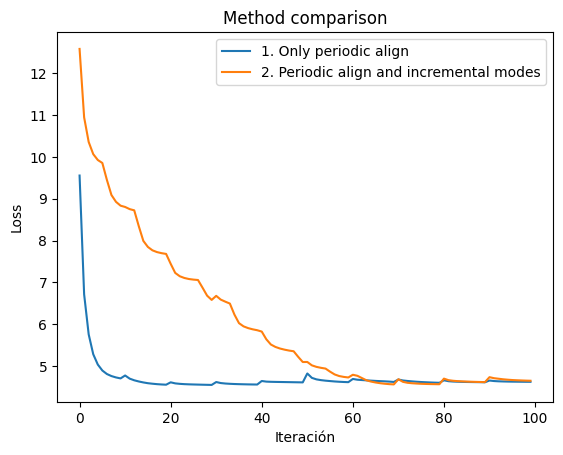

Loss mínimo method 1. : 4.54601278922567
Loss mínimo method 2. : 4.558156031118867


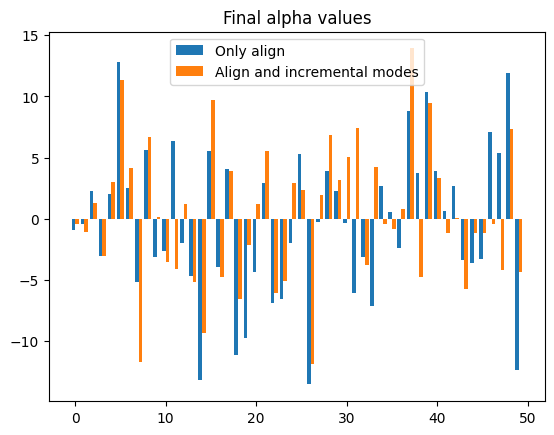

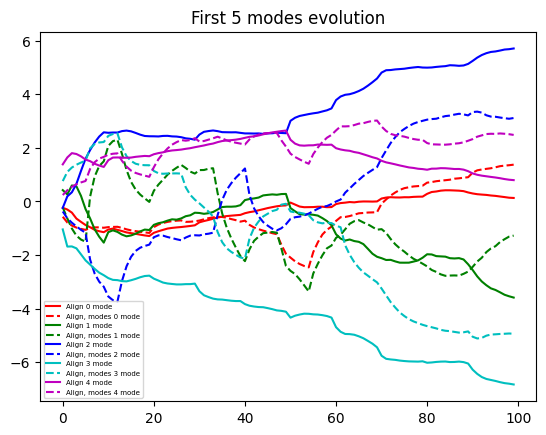

In [14]:
# Method comparison
num_iter=100
loss_methods, alpha_fin_methods, alpha_methods, data_segm_methods, slices_methods = comp_methods(
                            data_segm, slices,  n_modes=50, num_iter=num_iter, mode_incr_period=7, align_period=10)
iter = range(num_iter)
plt.plot(iter, loss_methods[0], label = '1. Only periodic align')
plt.plot(iter, loss_methods[1], label = '2. Periodic align and incremental modes')
plt.xlabel('Iteración')
plt.ylabel('Loss')
plt.title('Method comparison')
plt.legend()
plt.show()
print('Loss mínimo method 1. : ' + str(min(loss_methods[0])))
print('Loss mínimo method 2. : ' + str(min(loss_methods[1])))

alpha_opt_1 = alpha_fin_methods[0]
alpha_opt_2 = alpha_fin_methods[1]

rng = np.array(range(50))
plt.bar(rng-0.2, alpha_opt_1[:50], 0.4, label = 'Only align')
plt.bar(rng+0.2, alpha_opt_2[:50], 0.4, label = 'Align and incremental modes')
plt.title('Final alpha values')
plt.legend()
plt.show()
colors = ['r', 'g', 'b', 'c', 'm']

alpha_1 = np.array([a[:5] for a in alpha_methods[0]])
alpha_2 = np.array([a[:5] for a in alpha_methods[1]])

for i in range(5):
  plt.plot(range(100), alpha_1[:,i], label='Align {} mode'.format(i), color=colors[i])
  plt.plot(range(100), alpha_2[:,i], label='Align, modes {} mode'.format(i), color=colors[i], linestyle='--' )
plt.legend(fontsize = 5)
plt.title('First 5 modes evolution')
plt.show()

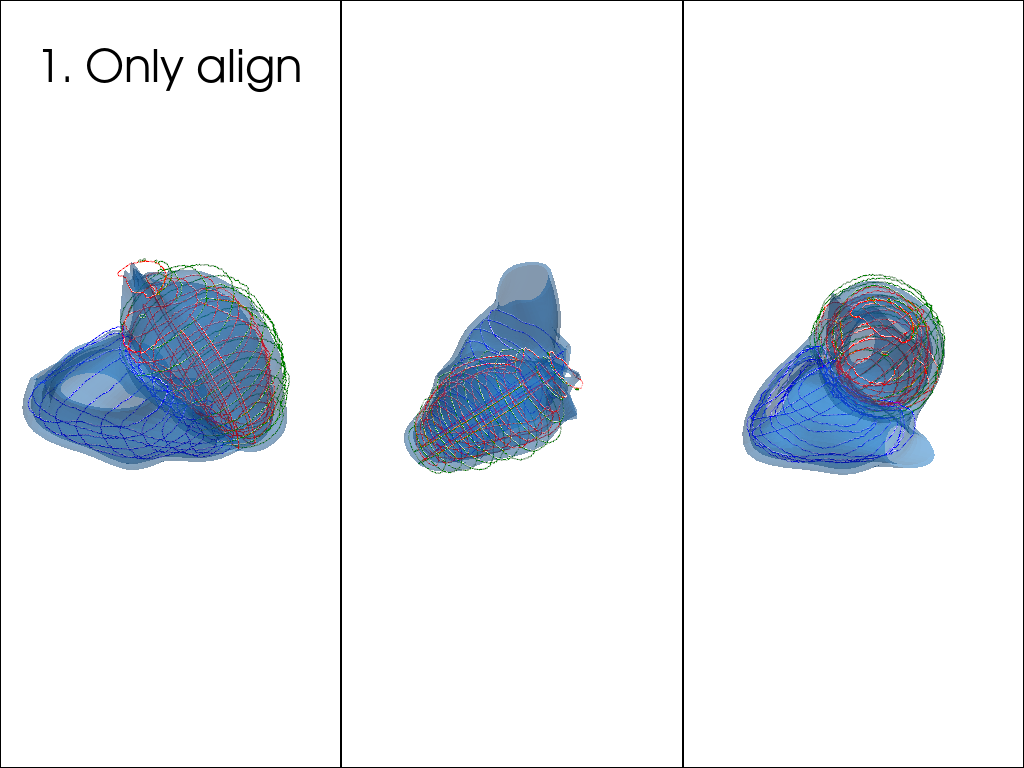

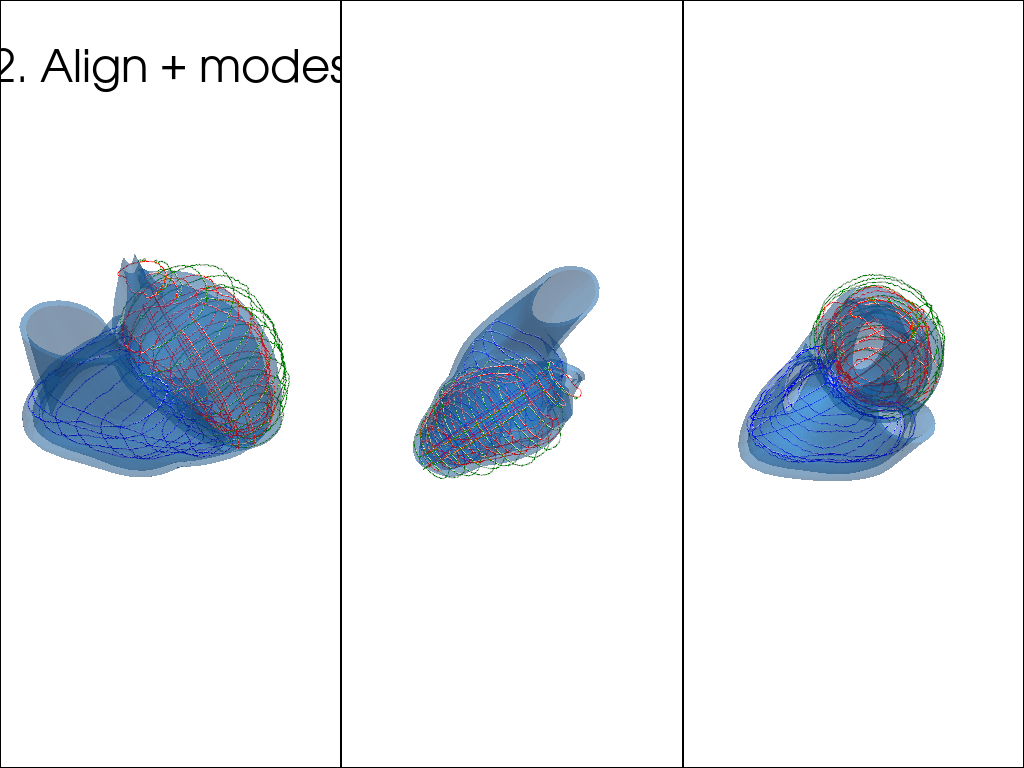

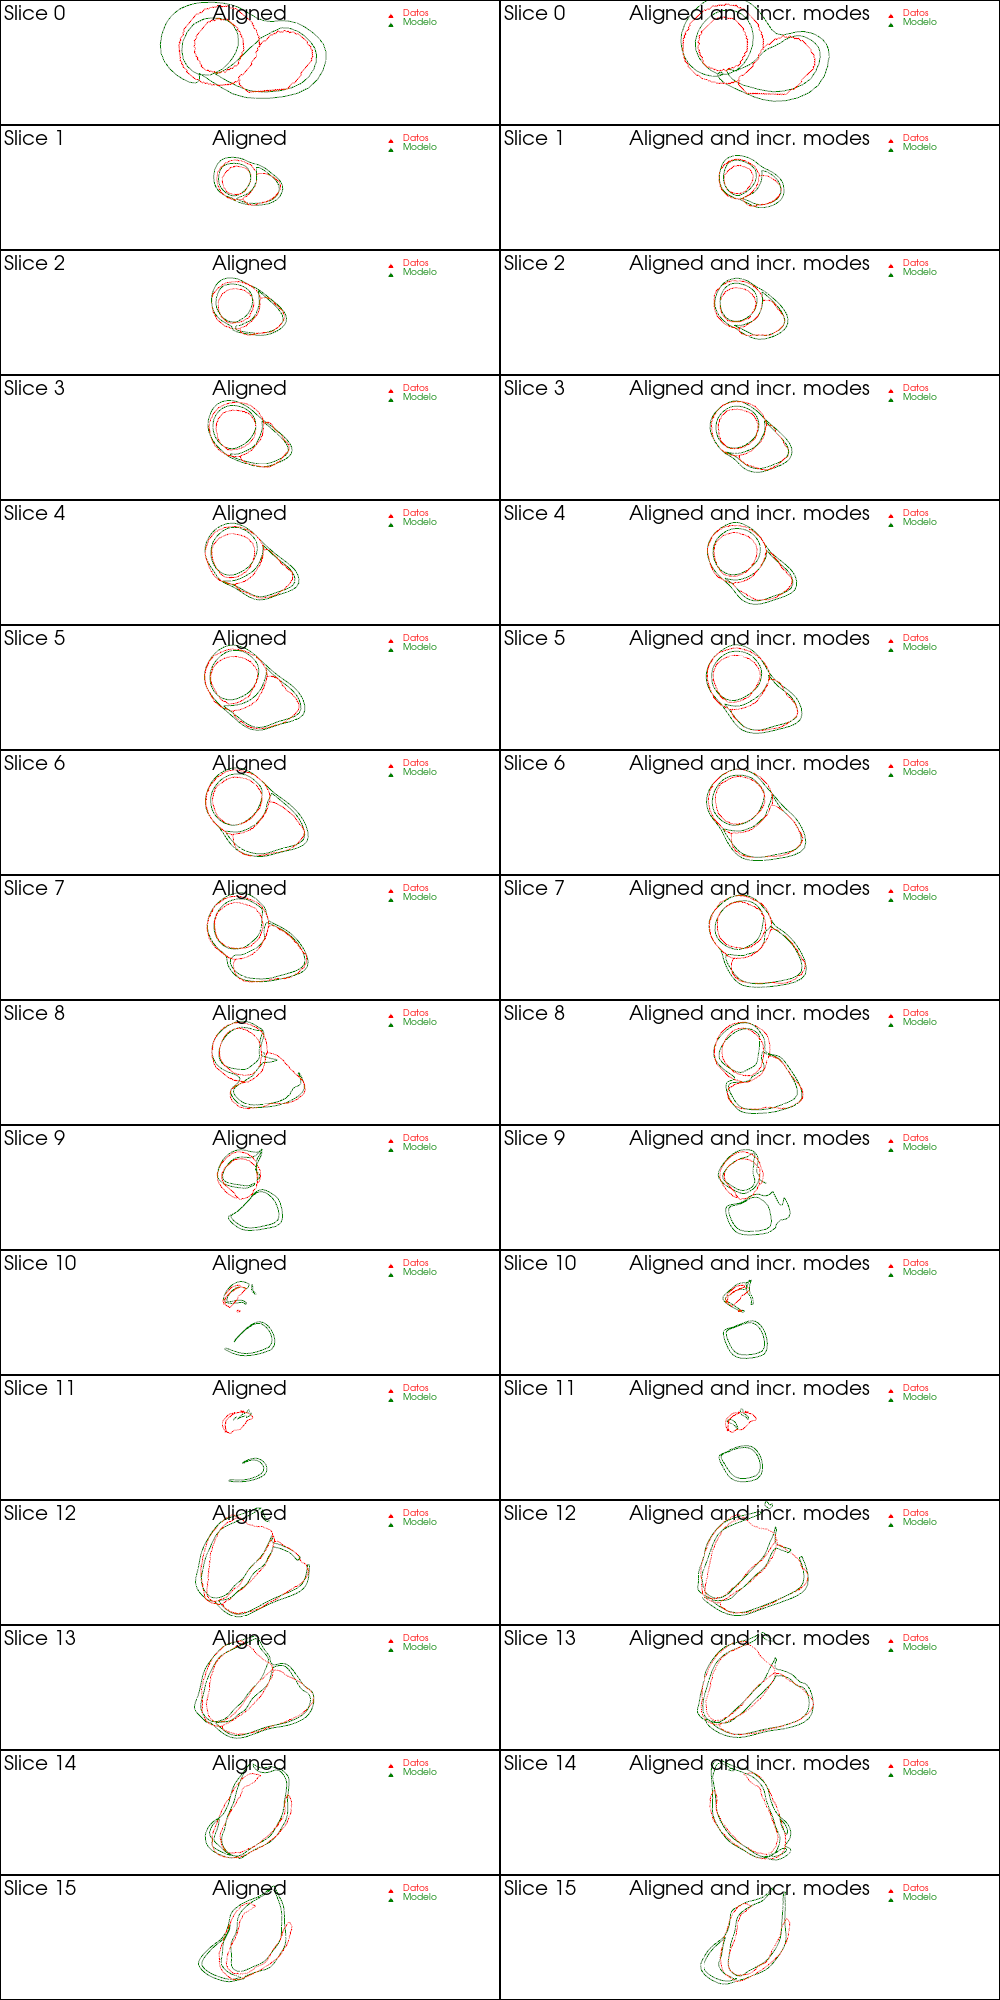

In [15]:
# visualization of  methods
plot_data_model(data_segm_methods[0], alpha_opt_1, '1. Only align')
plot_data_model(data_segm_methods[1], alpha_opt_2, '2. Align + modes')

plot_slices_comp(slices_methods[0], slices_methods[1], alpha_opt_1, alpha_opt_2)

## Test for pacient 0771

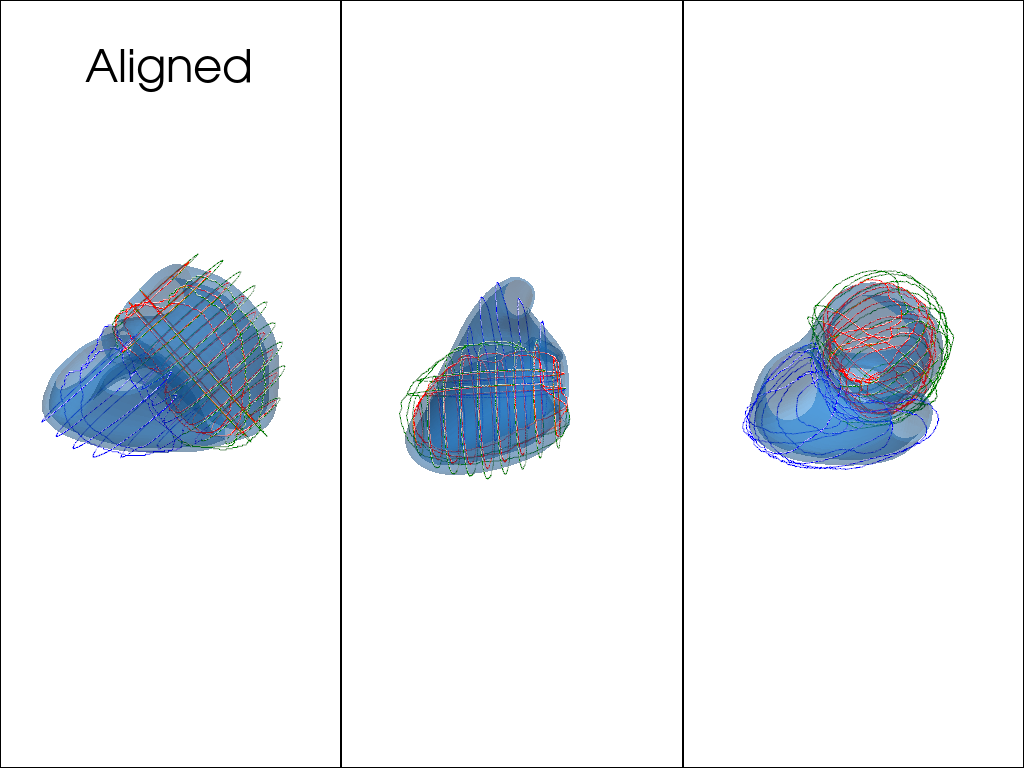

In [ ]:
data_segm_4CH, slices_4CH = nifti_to_mesh('0771_4CH_ED_segm.nii', axis='4CH')
LV_4CH, RV_4CH, EPI_4CH = data_segm_4CH
data_segm_EC, slices_EC = nifti_to_mesh('0771_EC_ED_segm.nii', axis='EC')
LV_EC, RV_EC, EPI_EC = data_segm_EC
data_segm_ELVI, slices_ELVI = nifti_to_mesh('0771_ELVI_ED_segm.nii', axis='ELVI')
LV_ELVI, RV_ELVI, EPI_ELVI = data_segm_ELVI

LV_0771 = pv.merge([LV_4CH, LV_EC, LV_ELVI])
RV_0771 = pv.merge([RV_4CH, RV_EC, RV_ELVI])
EPI_0771 = pv.merge([EPI_4CH, EPI_EC, EPI_ELVI])
data_segm = [LV_0771, RV_0771, EPI_0771]
slices = np.concatenate((slices_EC, slices_4CH, slices_ELVI))

# manual pre align
transl = (-125.335, 20.9198, -3.51031)
rot = (-18.0818, 8.92402, -164.504)

for segm in data_segm:
  segm.rotate_x(rot[0], inplace=True)
  segm.rotate_y(rot[1], inplace=True)
  segm.rotate_z(rot[2], inplace=True)
  segm.translate(transl, inplace=True)
for sl in slices:
  sl.rotate_x(rot[0], inplace=True)
  sl.rotate_y(rot[1], inplace=True)
  sl.rotate_z(rot[2], inplace=True)
  sl.translate(transl, inplace=True)

# automatic align
data_segm, slices = align_to_ATLAS(data_segm, slices)
plot_data_model(data_segm, np.zeros(1), 'Aligned')

Valor de alpha inicial: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
Valor de alpha final: [  0.39436909  -3.50771641   3.74259907   0.2937998   -1.7657151
  -1.33315765   7.37921084   2.19557448  -3.38093188   1.23824749
  -7.77742928   2.52106489   0.30022197  -4.65302433  -9.10315391
   0.0249072   -3.96589736  -2.94686159  12.64142683   4.01604689
   1.72228856  -3.29658988   1.1871643    1.51004798   1.74892443
   6.55023186   4.49580918   8.52420474 -12.49659828   1.29505497
   2.62985739   7.20059329  -0.30009358   6.35930631  -2.48460653
   3.1142353    0.69564441   1.91227116   0.7441544    6.25448425
  -2.50930911   6.94321918   4.01416105  -5.86802343  -0.29604678
  -2.97322483  -7.98048686  -2.48810334   4.79193566  -2.67551667]
Valor de alpha inicial: [0. 0. 0. 0. 0.]
Valor de alpha final: [ -1.36331618  -1.60112106   0.63344242   2.91737887  -0.7560064
  -5.1219818

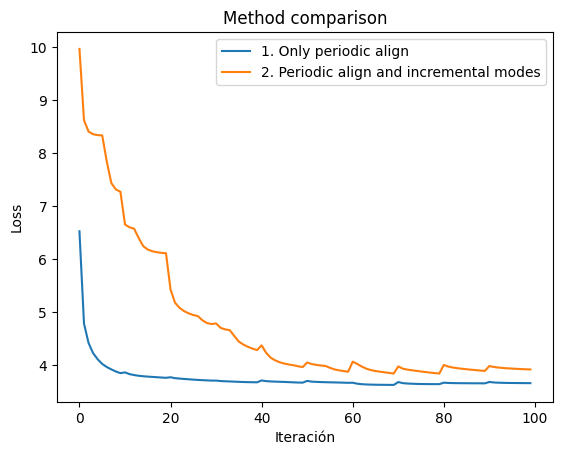

Loss mínimo method 1. : 3.6306654893423307
Loss mínimo method 2. : 3.8449172583695943


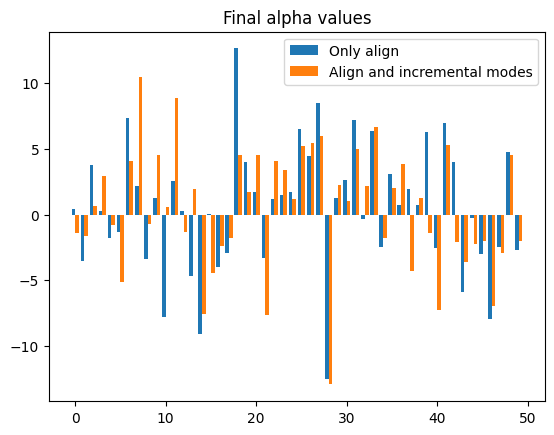

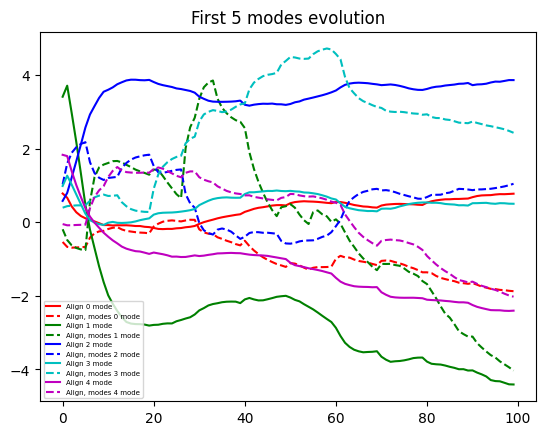

In [ ]:
# Method comparison
num_iter=100
loss_methods, alpha_fin_methods, alpha_methods, data_segm_methods, slices_methods = comp_methods(
                            data_segm, slices,  n_modes=50, num_iter=num_iter, mode_incr_period=7, align_period=10)
iter = range(num_iter)
plt.plot(iter, loss_methods[0], label = '1. Only periodic align')
plt.plot(iter, loss_methods[1], label = '2. Periodic align and incremental modes')
plt.xlabel('Iteración')
plt.ylabel('Loss')
plt.title('Method comparison')
plt.legend()
plt.show()
print('Loss mínimo method 1. : ' + str(min(loss_methods[0])))
print('Loss mínimo method 2. : ' + str(min(loss_methods[1])))

alpha_opt_1 = alpha_fin_methods[0]
alpha_opt_2 = alpha_fin_methods[1]

rng = np.array(range(50))
plt.bar(rng-0.2, alpha_opt_1[:50], 0.4, label = 'Only align')
plt.bar(rng+0.2, alpha_opt_2[:50], 0.4, label = 'Align and incremental modes')
plt.title('Final alpha values')
plt.legend()
plt.show()
colors = ['r', 'g', 'b', 'c', 'm']

alpha_1 = np.array([a[:5] for a in alpha_methods[0]])
alpha_2 = np.array([a[:5] for a in alpha_methods[1]])

for i in range(5):
  plt.plot(range(100), alpha_1[:,i], label='Align {} mode'.format(i), color=colors[i])
  plt.plot(range(100), alpha_2[:,i], label='Align, modes {} mode'.format(i), color=colors[i], linestyle='--' )
plt.legend(fontsize = 5)
plt.title('First 5 modes evolution')
plt.show()

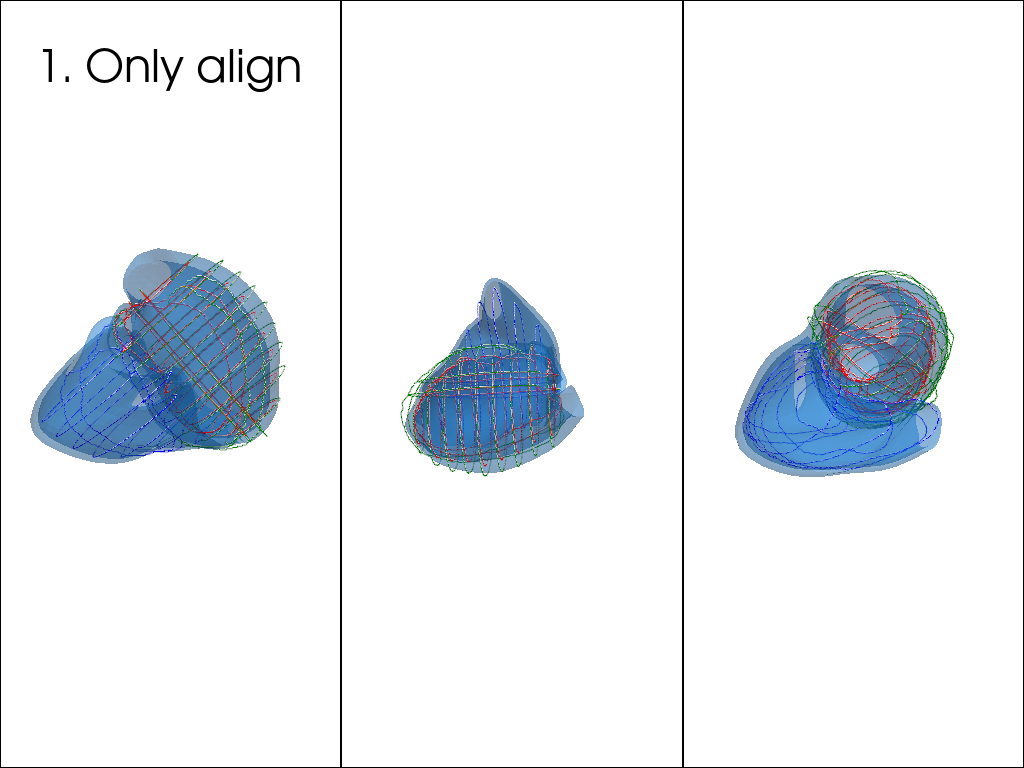

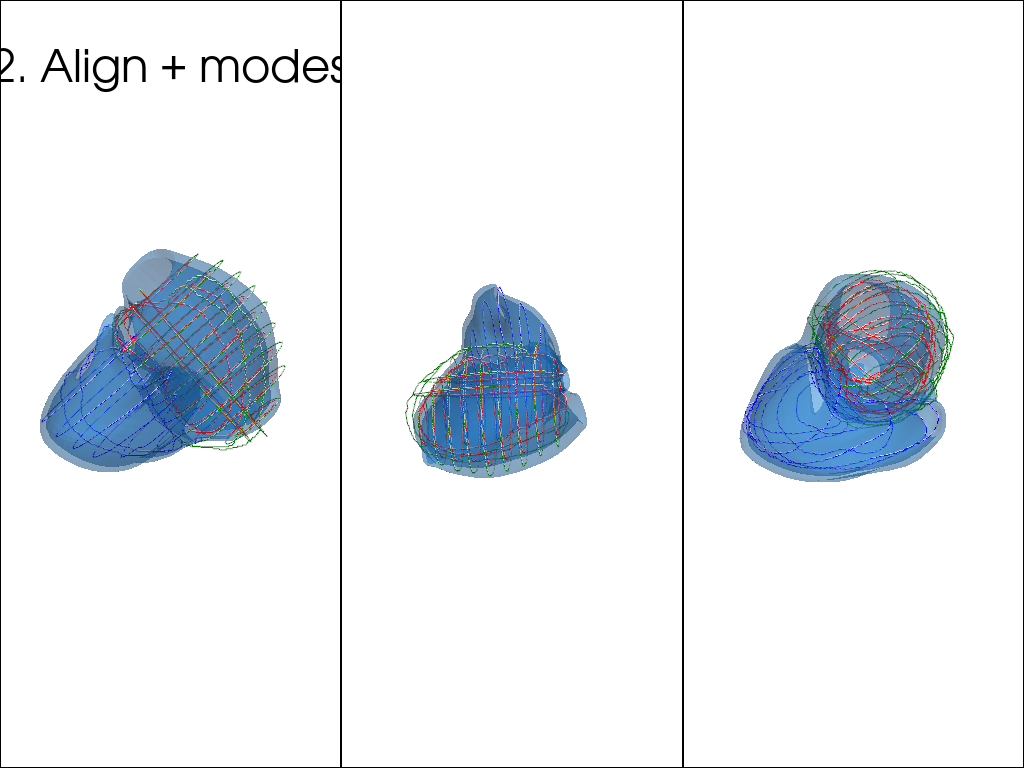

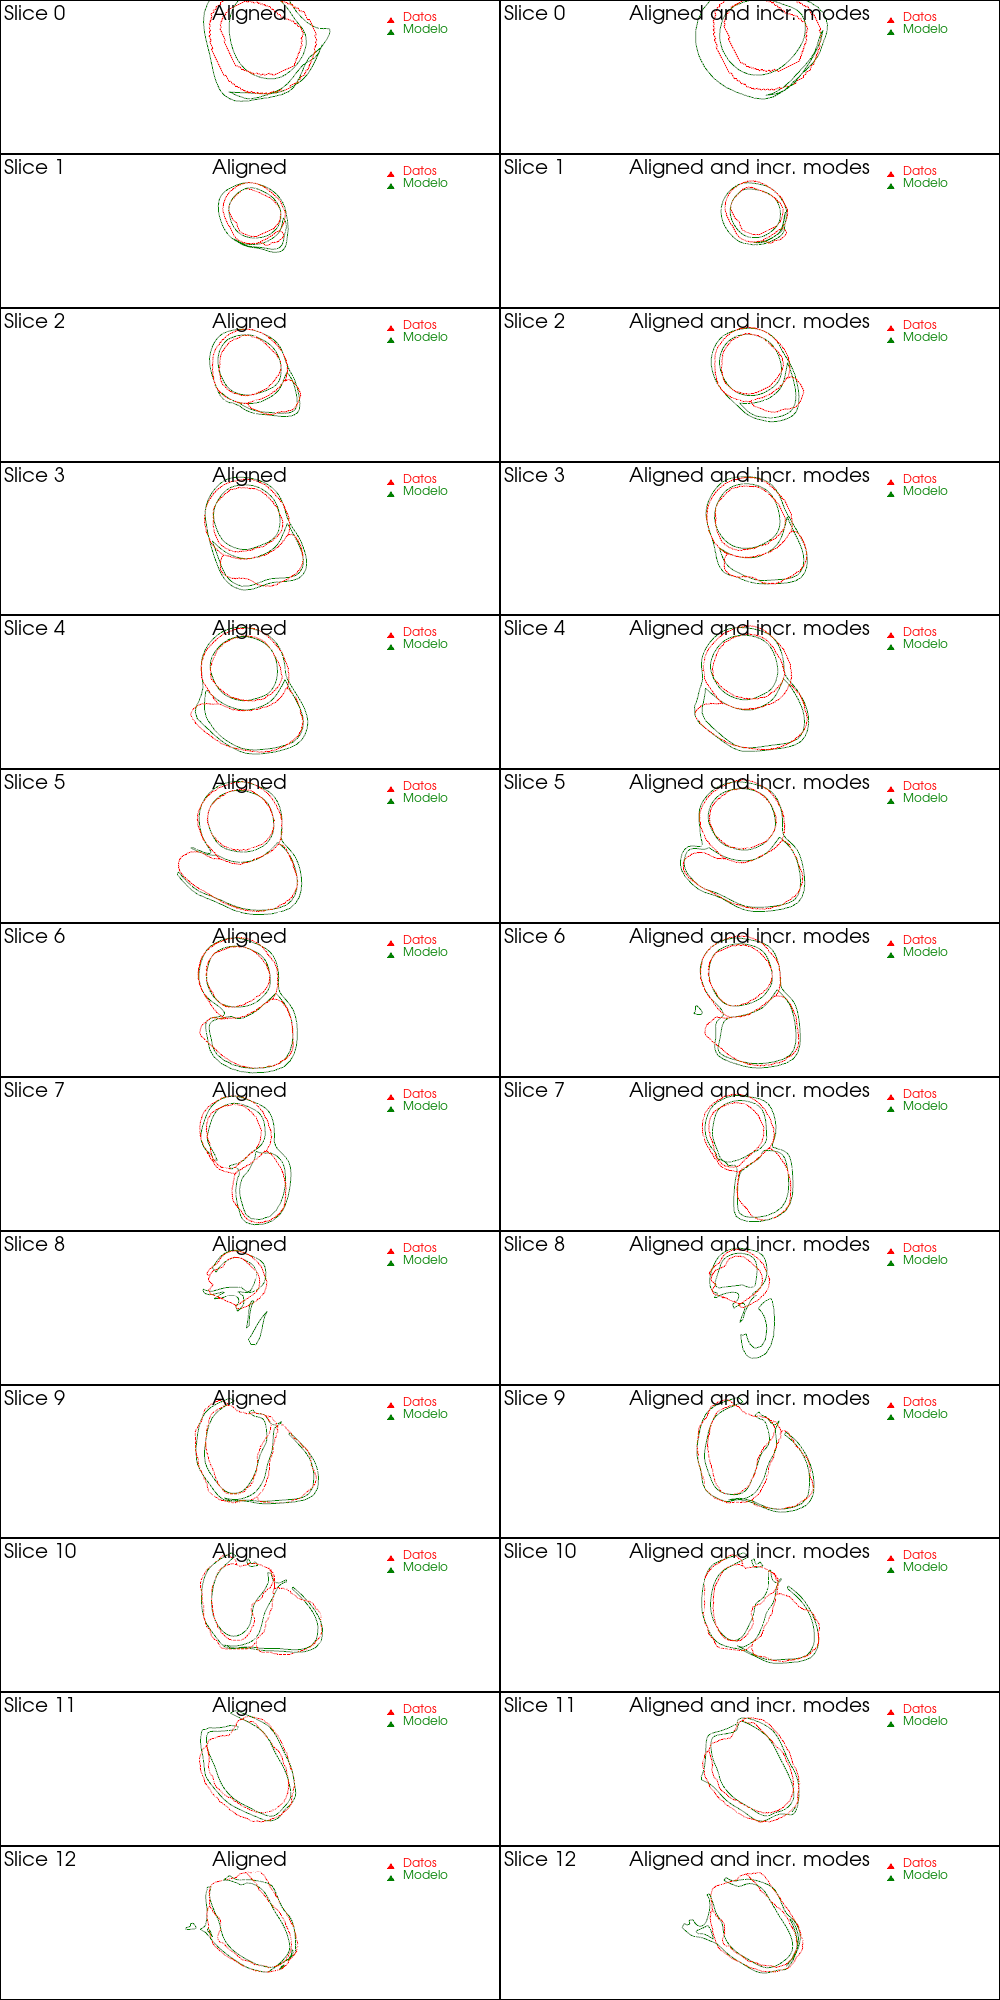

In [ ]:
# visualization of  methods
plot_data_model(data_segm_methods[0], alpha_opt_1, '1. Only align')
plot_data_model(data_segm_methods[1], alpha_opt_2, '2. Align + modes')

plot_slices_comp(slices_methods[0], slices_methods[1], alpha_opt_1, alpha_opt_2)